# Natural Language Processing Project

In this project,we will attempt to classify Yelp reviews into 1 star to 5 stars categories based off the text content in the reviews.
We will use the Yelp Review Data Set from Kaggle.

Each observation in this dataset is a review of a particular business by a particular user.

The "stars" column is the number of stars (1 through 5) assigned by the reviewer to the business. (Higher stars is better.) In other words, it is the rating of the business by the person who wrote the review.

The "cool" column is the number of "cool" votes this review received from other Yelp users. 

IMPORT LIBRARIES

In [1]:
import numpy as np
import pandas as pd

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [47]:
from sklearn.feature_extraction.text import CountVectorizer

In [48]:
from sklearn.model_selection import train_test_split

THE DATA

In [3]:
yelp = pd.read_csv('yelp.csv')

In [4]:
yelp.head(3)

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0


In [5]:
yelp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   business_id  10000 non-null  object
 1   date         10000 non-null  object
 2   review_id    10000 non-null  object
 3   stars        10000 non-null  int64 
 4   text         10000 non-null  object
 5   type         10000 non-null  object
 6   user_id      10000 non-null  object
 7   cool         10000 non-null  int64 
 8   useful       10000 non-null  int64 
 9   funny        10000 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 781.4+ KB


In [6]:
yelp.describe()

,stars,cool,useful,funny
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.777500,0.876800,1.409300,0.701300
std,1.214636,2.067861,2.336647,1.907942
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,1.000000,0.000000
75%,5.000000,1.000000,2.000000,1.000000
max,5.000000,77.000000,76.000000,57.000000


Next, we will create a new column called "text length" that will contain the number of words in the "text" column.

In [7]:
yelp['text length'] = yelp['text'].apply(len)

EXPLORATORY DATA ANALYSIS

In [15]:
sns.set_style('white')

We will use FacetGrid to create a grid of 5 histograms of text length based off of the star rating.

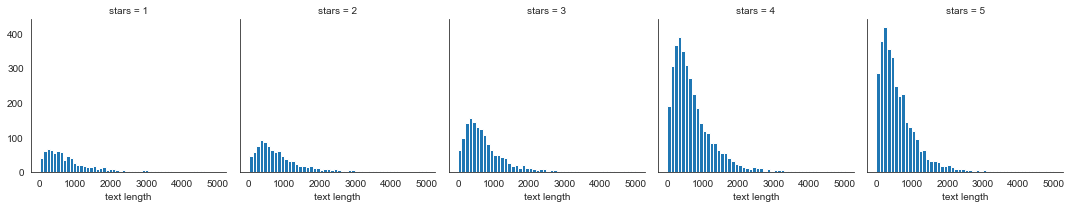

In [19]:
g = sns.FacetGrid(yelp, col='stars')
g.map(plt.hist, 'text length', bins=50)

From the plots, it seems that the distribution for text length is the same for all number of stars.
The amount of text reviews seems to be a lot higher for 4 stars and 5 stars.

We will create a box plot of text length for each star category.

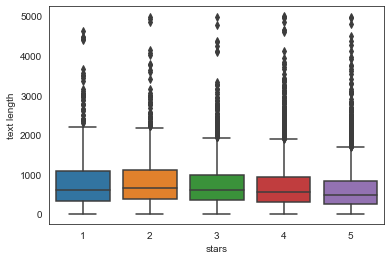

In [20]:
sns.boxplot(x='stars', y='text length', data=yelp)

We will create a count plot with the number of occurances for each type of star rating.

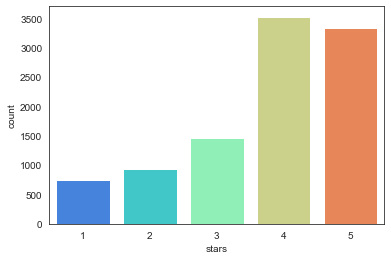

In [21]:
sns.countplot(data=yelp, x='stars',palette='rainbow')

We have higher amounts of 4 and 5 stars reviews.

We will use groupby to get the mean values for all the numerical columns.

In [23]:
stars = yelp.groupby('stars').mean()
stars

,cool,useful,funny,text length
stars,,,,
1,0.576769,1.604806,1.056075,826.515354
2,0.719525,1.563107,0.875944,842.256742
3,0.788501,1.306639,0.694730,758.498289
4,0.954623,1.395916,0.670448,712.923142
5,0.944261,1.381780,0.608631,624.999101


In [24]:
stars.corr()

,cool,useful,funny,text length
cool,1.000000,-0.743329,-0.944939,-0.857664
useful,-0.743329,1.000000,0.894506,0.699881
funny,-0.944939,0.894506,1.000000,0.843461
text length,-0.857664,0.699881,0.843461,1.000000


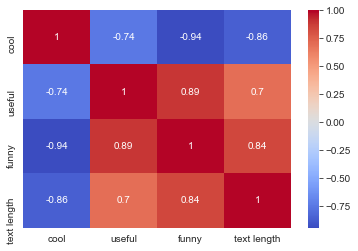

In [25]:
sns.heatmap(stars.corr(), cmap='coolwarm', annot=True)

NLP Classification Task

We will grab the reviews that have either 1 star, or 5 stars.

In [26]:
yelp_class = yelp[(yelp['stars'] == 1) | (yelp['stars'] == 5)]
yelp_class.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,text length
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,889
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0,1345
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0,419
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0,469
6,zp713qNhx8d9KCJJnrw1xA,2010-02-12,riFQ3vxNpP4rWLk_CSri2A,5,Drop what you're doing and drive here. After I...,review,wFweIWhv2fREZV_dYkz_1g,7,7,4,1565


The feature(the acctual text reviews):

In [44]:
X = yelp_class['text']

The target(labels):

In [29]:
y = yelp_class['stars']

In [45]:
cv = CountVectorizer()
X = cv.fit_transform(X)

TRAIN TEST SPLIT

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

TRAIN THE MODEL

We will use Naive Bayes classifier.

In [50]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [51]:
nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

PREDICTIONS AND EVALUATIONS

In [52]:
predictions = nb.predict(X_test)

We will create a confusion matrix and classification report using these predictions and y_test.

In [53]:
from sklearn.metrics import confusion_matrix, classification_report

In [54]:
print("Confusion matrix: ")
print(confusion_matrix(y_test, predictions))
print('\n')
print("Classification report: ")
print(classification_report(y_test, predictions))

Confusion matrix: 
[[159  69]
 [ 22 976]]


Classification report: 
              precision    recall  f1-score   support

           1       0.88      0.70      0.78       228
           5       0.93      0.98      0.96       998

    accuracy                           0.93      1226
   macro avg       0.91      0.84      0.87      1226
weighted avg       0.92      0.93      0.92      1226



We will see what it happens if we include TF-IDF using pipelines to this process.

USING TEXT PROCESSING

In [55]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

We will create a pipeline with the following steps: CountVectorizer(), TfIdfTransformer(), MultinomialNB()

In [56]:
pipe = Pipeline([('bow', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', MultinomialNB())])

USING the PIPELINE

The pipeline has all the pre-processed steps already in it.We will need to re-split the original data.

In [57]:
X = yelp_class['text']
y = yelp_class['stars']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

We will fit the pipeline to the training data,we need to pass just the text and labels.

In [58]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('model',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

PREDICTIONS AND EVALUATIONS

In [59]:
predictions = pipe.predict(X_test)

In [60]:
print("Confusion matrix: ")
print(confusion_matrix(y_test, predictions))
print('\n')
print("Classification report: ")
print(classification_report(y_test, predictions))

Confusion matrix: 
[[  0 228]
 [  0 998]]


Classification report: 
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       228
           5       0.81      1.00      0.90       998

    accuracy                           0.81      1226
   macro avg       0.41      0.50      0.45      1226
weighted avg       0.66      0.81      0.73      1226



C:\Users\bianca\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
